<a href="https://colab.research.google.com/github/DOOMNOVA/MultiNERD-English-/blob/main/MultiNERD_system_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# run cell to install packages
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install seqeval
!pip install evaluate
!pip install pipreqs
!pip install -U "huggingface_hub[cli]"
!pip install scikit-learn seaborn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=22674374df4c16979a64ac6d3c7394cbae8bf45b09587a19592ef2c1068fcbc6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=69a645375dd34e87869e60fe6a80938061d697948eaa634ab141c3

## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import transformers
from datasets import load_dataset, load_metric
from transformers import DistilBertForTokenClassification, DistilBertTokenizerFast, TrainingArguments, Trainer , pipeline, DataCollatorForTokenClassification
import evaluate
#import wandb
#import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
"login to hugging face to upload model to hub later - uncomment code if needed"
#from huggingface_hub import notebook_login
#notebook_login(True)


## Load the MultiNERD dataset

In [4]:
# download the dataset
data = "Babelscape/multinerd"
dataset = load_dataset(data)


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Preprocessing stage
### Specifiy the label values, filter english examples





In [5]:
id2label = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }
label2id = {value: key for key, value in id2label.items()}
label_list = list(id2label.keys())

In [6]:
#Filter out non-english examples from all three splits of datasets
data_eng = dataset.filter(lambda x: x['lang']=='en')



Filter:   0%|          | 0/2678400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/334800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/335986 [00:00<?, ? examples/s]

## Tokenizer and format function

In [7]:
#load tokenizer for distilbert
model_name = 'distilbert-base-cased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

#helper function for tokenizing and formating the ner dataset --- reference - code used from https://huggingface.co/docs/transformers/v4.35.2/en/tasks/token_classification#evaluate
def format_and_tokenize(dataset_eng):
  tokenized_inputs = tokenizer(dataset_eng['tokens'],truncation=True,is_split_into_words=True)

  labels = []
  for i, label in enumerate(dataset_eng[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None

        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

  tokenized_inputs["labels"] = labels

  return tokenized_inputs







tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [8]:
#format and tokenize the dataset
data_eng = data_eng.map(format_and_tokenize,batched=True)


Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

## Define datacollator and function for computing a suite of metrics

In [9]:
datacollator = DataCollatorForTokenClassification(tokenizer)

metric = evaluate.load('seqeval')

#reference - code used from - https://huggingface.co/docs/transformers/v4.35.2/en/tasks/token_classification#evaluate

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]

    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],

        "recall": results["overall_recall"],

        "f1": results["overall_f1"],

        "accuracy": results["overall_accuracy"],
    }



## Finetuning to develop System A

In [10]:
#load system_A for fine tuning
system_A = DistilBertForTokenClassification.from_pretrained(model_name,num_labels = len(label_list),id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:

# specify training arguments

training_args = TrainingArguments(
    output_dir = './distilbert_system_A',
    per_device_train_batch_size = 32,
    per_device_eval_batch_size =  32,
    num_train_epochs = 3,
    weight_decay = 0.01,
    evaluation_strategy='epoch',
    save_strategy= 'epoch',
    load_best_model_at_end=True,
    learning_rate = 2e-5,

)

In [12]:
#fine-tuning system A
trainer = Trainer(
    model = system_A,
    args = training_args,
    train_dataset = data_eng['train'],
    eval_dataset = data_eng['validation'],
    tokenizer = tokenizer,
    data_collator = datacollator,
    compute_metrics = compute_metrics

)
trainer.train()


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.027800,0.043428,0.899215,0.897661,0.898438,0.984299
2,0.016100,0.047714,0.906741,0.906532,0.906636,0.985058
3,0.009700,0.054682,0.899565,0.913175,0.906319,0.985037


TrainOutput(global_step=24615, training_loss=0.02577266853901276, metrics={'train_runtime': 5066.3176, 'train_samples_per_second': 155.474, 'train_steps_per_second': 4.859, 'total_flos': 1.3390337265985536e+16, 'train_loss': 0.02577266853901276, 'epoch': 3.0})

In [13]:
#save model
trainer.save_model('./fine_tuned_system_A_ner')

## Test performance of System A with the Test set

In [14]:
#save test metric results
test_metrics = trainer.evaluate(data_eng['test'],metric_key_prefix='test')
trainer.save_metrics('test',test_metrics)

In [15]:
# test metrics for individual entity types

predictions, labels, _ = trainer.predict(data_eng["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'ANIM': {'precision': 0.6946249261665682,
  'recall': 0.7331670822942643,
  'f1': 0.7133757961783439,
  'number': 3208},
 'BIO': {'precision': 0.3333333333333333,
  'recall': 0.25,
  'f1': 0.28571428571428575,
  'number': 16},
 'CEL': {'precision': 0.825,
  'recall': 0.8048780487804879,
  'f1': 0.8148148148148149,
  'number': 82},
 'DIS': {'precision': 0.7109067017082786,
  'recall': 0.7127799736495388,
  'f1': 0.7118421052631579,
  'number': 1518},
 'EVE': {'precision': 0.9303621169916435,
  'recall': 0.9488636363636364,
  'f1': 0.939521800281294,
  'number': 704},
 'FOOD': {'precision': 0.60801393728223,
  'recall': 0.6166077738515902,
  'f1': 0.612280701754386,
  'number': 1132},
 'INST': {'precision': 0.45,
  'recall': 0.75,
  'f1': 0.5625000000000001,
  'number': 24},
 'LOC': {'precision': 0.9929988331388565,
  'recall': 0.990851630073187,
  'f1': 0.9919240696028641,
  'number': 24048},
 'MEDIA': {'precision': 0.9175257731958762,
  'recall': 0.9716157205240175,
  'f1': 0.94379639

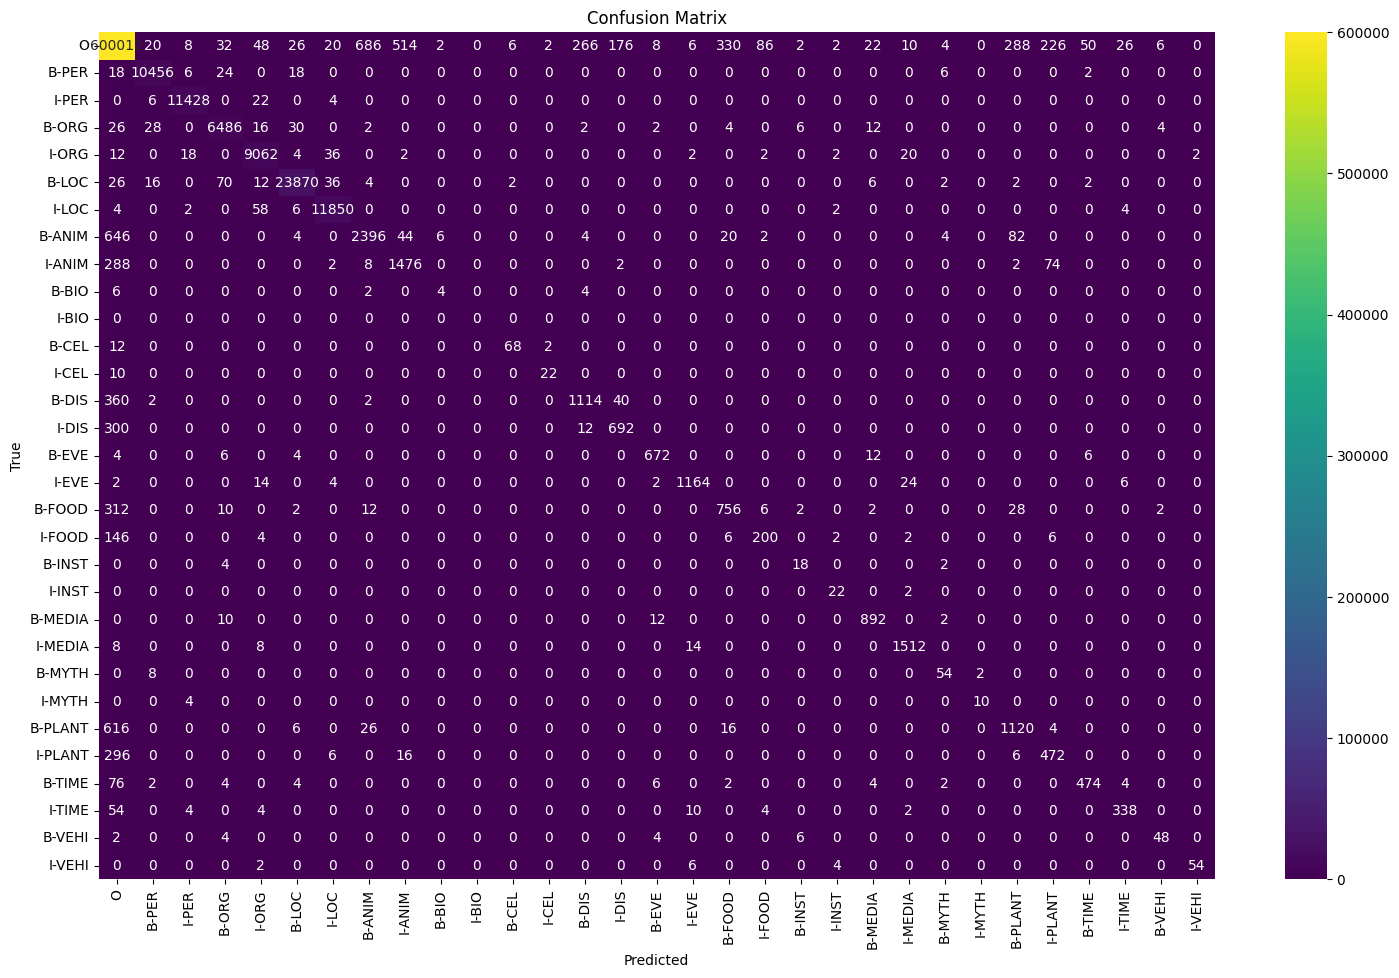

In [33]:
# plot the confusion matrix for the test dataset

# Flatten the lists
flat_true_labels = [label for sublist in true_labels for label in sublist]
flat_true_predictions = [label for sublist in true_predictions for label in sublist]

# Create a confusion matrix
conf_mat = confusion_matrix(flat_true_labels, flat_true_predictions, labels=label_list)

# Plot the confusion matrix
plt.figure(figsize=(18, 11))
sns.heatmap(conf_mat, annot=True,fmt="d", cmap="viridis", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix_system_A.png')
plt.show()

In [19]:
# save the model to hugging face
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

events.out.tfevents.1702392525.a84a099a6836.170.0:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1702397678.a84a099a6836.170.1:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

'https://huggingface.co/doomnova/distilbert_system_A/tree/main/'

In [28]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# save pipe.pkl to output data folder
!#cp -r final_distilbert_system_A /content/drive/MyDrive/general

In [36]:
#!pip freeze > requirements.txt

In [37]:
#from google.colab import files

#files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>